# KAN vs MLP for Time Series Forecasting

## 1. Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from synthetic import simulate_var
from torch.utils.data import DataLoader, TensorDataset
from models.kan import KAN
from models.model_helper import activation_helper
from tqdm import tqdm, trange

# torch.set_default_dtype(torch.float64)

## 2. Hyperparameters

In [2]:
lag = 2  # number of lags
T = 1000  # number of time points
num_series = 5  # number of time series

batch_size = 32
epochs = 500
lr = 1e-3

dim_input = num_series * lag
dim_output = 1

## 3. Generate Data

In [3]:
# Simulate data with causal relationships
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=0.4)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

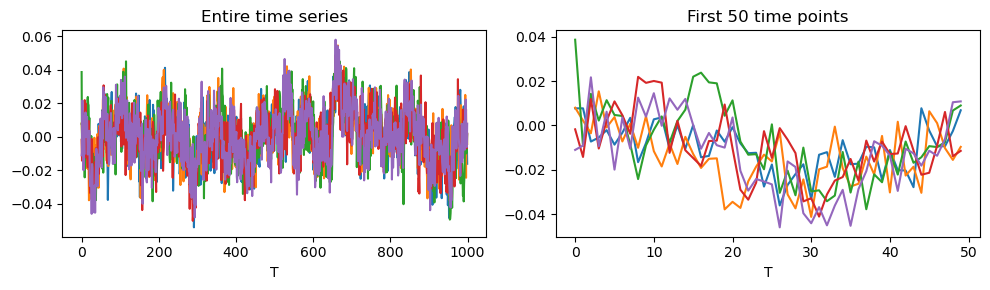

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

Plot the granger causality among time series

[[1 0 0 1 0]
 [1 1 0 0 0]
 [0 0 1 0 1]
 [0 1 0 1 0]
 [0 1 0 0 1]]


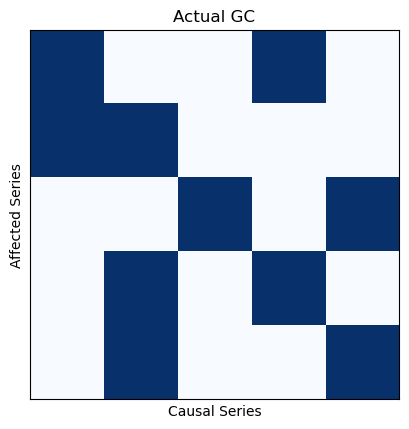

In [5]:
print(GC)

plt.imshow(GC, cmap='Blues')
plt.title('Actual GC')
plt.ylabel('Affected Series')
plt.xlabel('Causal Series')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.show()

## 4. Prepare the Data

- In this section, we choose TS1 as the target time series.

- The lags of the rest 4 series and TS1 itself will be used to predict the current value of TS1.

- For TS1, it is affected by TS0, TS1, TS3.

In [16]:
target_series = 1  # the series we want to predict

In [17]:
def pd_data(X):
    '''
    Use dataframe to show the data structure
    Y: target series
    ts{}_lag{}: value of time series {} with lag {}
    '''
    Y = X[:, :, target_series]
    df = pd.DataFrame({'Y': Y[0,:].detach().numpy()})[lag:]
    for i in range(num_series):
        for j in range(lag):
            df['ts{}_lag{}'.format(i, lag-j)] = X[0, :, i].detach().numpy()[j:-lag+j]
    return df

def rearrange_data(X):
    '''
    Rearrange the time series, to form a data with lags

    Input:
        X: tensor with shape (1, num_series, T)
    Output:
        array: tensor with shape (num_series * lag, T-lag)
    '''
    li = []
    for i in range(num_series):
        for j in range(lag):
            li.append(X[0, :, i].detach().numpy()[j:-lag+j])

    # transfer li to tensor
    array = torch.tensor(li, dtype=torch.float32)

    return array

In [18]:
array = rearrange_data(X).T
print(array.shape)

Y = X[:, :, target_series][0, :T-lag].reshape(1, T-lag).T
print(Y.shape)

# Show the data structure using dataframe
# pd_data(X)

# put the data into DataLoader
trainloader = DataLoader(TensorDataset(array, Y), batch_size=32, shuffle=True)

torch.Size([998, 10])
torch.Size([998, 1])


## 5. Predict using KAN

### 5.1 Explore how the layer width can affect the result. (Depth=1)

In [19]:
layers = [4, 16, 32, 128, 256]
kan_loss_width_all = []
kan_output_width_all = []

for layer in layers:
    model = KAN([dim_input, layer, dim_output], spline_order=5)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    with trange(epochs) as t:
        for epoch in t:
            # Train
            model.train()
            for i, data in enumerate(trainloader):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            kan_loss.append(loss.item())
            t.set_postfix(loss=loss.item())
            
    kan_output_width_all.append(model(array).detach().numpy())
    kan_loss_width_all.append(kan_loss)

    # for epoch in range(epochs):
    #     # Train
    #     model.train()
    #     for i, data in enumerate(trainloader):
    #         inputs, labels = data
    #         optimizer.zero_grad()
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
            
    #         loss.backward()
    #         optimizer.step()
            
    #     kan_loss.append(loss.item())
    #     if (epoch+1) % 100 == 0:
    #         print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    # kan_output_width_all.append(model(array).detach().numpy())
    # kan_loss_width_all.append(kan_loss)

----------
Hidden layer number:  4


100%|██████████| 500/500 [00:37<00:00, 13.17it/s, loss=7.77e-10]


----------
Hidden layer number:  16


100%|██████████| 500/500 [00:42<00:00, 11.76it/s, loss=1.15e-8] 


----------
Hidden layer number:  32


100%|██████████| 500/500 [01:10<00:00,  7.04it/s, loss=2.57e-9] 


----------
Hidden layer number:  128


100%|██████████| 500/500 [02:40<00:00,  3.11it/s, loss=3.98e-9] 


----------
Hidden layer number:  256


100%|██████████| 500/500 [04:43<00:00,  1.76it/s, loss=4.69e-9]


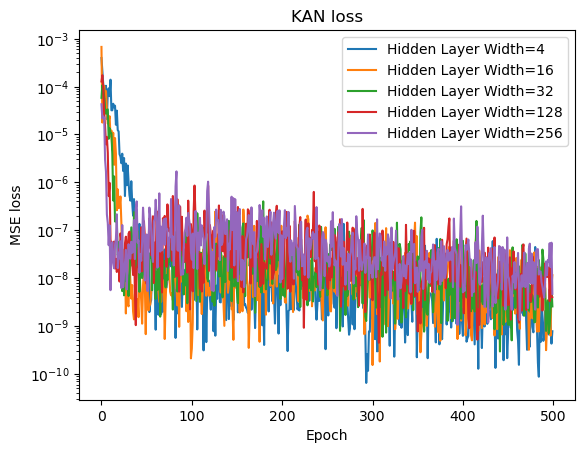

In [20]:
for i, kan_loss in enumerate(kan_loss_width_all):
    plt.plot(kan_loss, label='Hidden Layer Width={}'.format(layers[i]))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

### 5.2 Explore how layer depth can affect the result. (Width=4)

In [66]:
layers = [
    [dim_input, 4, dim_output],
    [dim_input, 4, 4, dim_output],
    [dim_input, 4, 4, 4, dim_output],
    [dim_input, 4, 4, 4, 4, dim_output],
    [dim_input, 4, 4, 4, 4, 4, dim_output]
]
kan_loss_depth_all = []
kan_output_depth_all = []

for i, layer in enumerate(layers):
    model = KAN(layer)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer depth: ", i+1)

    with trange(epochs) as t:
        for epoch in t:
            # Train
            model.train()
            for i, data in enumerate(trainloader):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            kan_loss.append(loss.item())
            t.set_postfix(loss=loss.item())

    kan_output_depth_all.append(model(array).detach().numpy())
    kan_loss_depth_all.append(kan_loss)

----------
Hidden layer depth:  1


100%|██████████| 500/500 [00:36<00:00, 13.83it/s, loss=5.13e-9] 


----------
Hidden layer depth:  2


100%|██████████| 500/500 [00:45<00:00, 10.95it/s, loss=1.09e-8] 


----------
Hidden layer depth:  3


100%|██████████| 500/500 [00:59<00:00,  8.47it/s, loss=5.88e-10]


----------
Hidden layer depth:  4


100%|██████████| 500/500 [01:13<00:00,  6.82it/s, loss=4.59e-9] 


----------
Hidden layer depth:  5


100%|██████████| 500/500 [01:21<00:00,  6.16it/s, loss=8.63e-10]


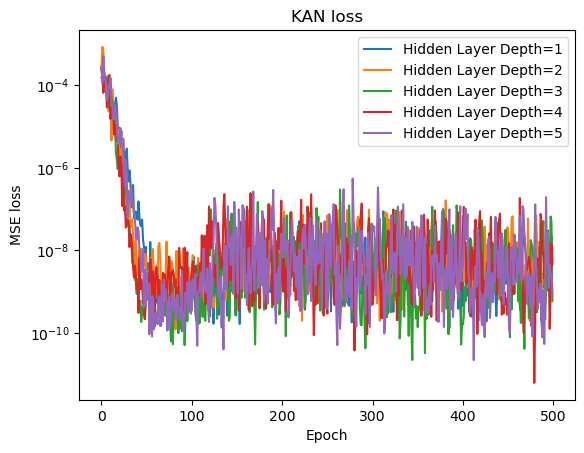

In [67]:
for i, kan_loss in enumerate(kan_loss_depth_all):
    plt.plot(kan_loss, label='Hidden Layer Depth={}'.format(i+1))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

## 6. Predict using MLP

In [26]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.layers.append(activation_helper('tanh'))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [27]:
layers = [4, 16, 32, 128, 256]
mlp_loss_all = []
mlp_output_all = []

for layer in layers:
    model = MLP([dim_input, layer, dim_output])
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    mlp_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    with trange(epochs) as t:
        for epoch in t:
            # Train
            model.train()
            for i, data in enumerate(trainloader):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            mlp_loss.append(loss.item())
            t.set_postfix(loss=loss.item())

    mlp_output_all.append(model(array).detach().numpy())
    mlp_loss_all.append(mlp_loss)

    # for epoch in range(epochs):
    #     # Train
    #     model.train()
    #     for i, data in enumerate(trainloader):
    #         inputs, labels = data
    #         optimizer.zero_grad()
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
            
    #         loss.backward()
    #         optimizer.step()
            
    #     mlp_loss.append(loss.item())
    #     if (epoch+1) % 100 == 0:
    #         print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    # mlp_output_all.append(model(array).detach().numpy())
    # mlp_loss_all.append(mlp_loss)

----------
Hidden layer number:  4


100%|██████████| 500/500 [00:16<00:00, 30.64it/s, loss=1.25e-9] 


----------
Hidden layer number:  16


100%|██████████| 500/500 [00:12<00:00, 39.27it/s, loss=2.25e-9] 


----------
Hidden layer number:  32


100%|██████████| 500/500 [00:12<00:00, 40.65it/s, loss=1.25e-7] 


----------
Hidden layer number:  128


100%|██████████| 500/500 [00:16<00:00, 29.94it/s, loss=2.25e-9] 


----------
Hidden layer number:  256


100%|██████████| 500/500 [00:21<00:00, 23.18it/s, loss=8.2e-11] 


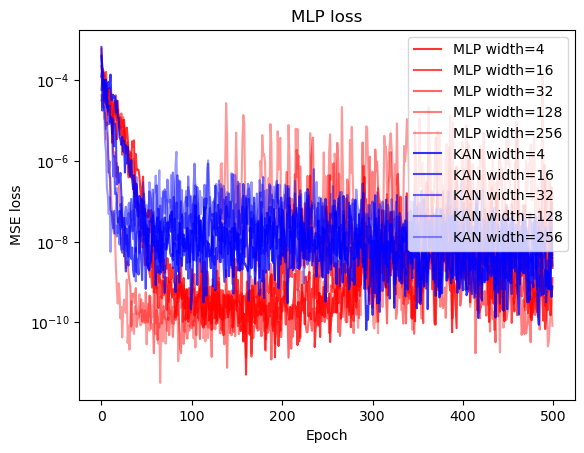

In [29]:
for i, mlp_loss in enumerate(mlp_loss_all):
    plt.plot(mlp_loss, label='MLP width={}'.format(layers[i]), alpha=0.8 - 0.1*i, color='red')
for i, kan_loss in enumerate(kan_loss_width_all):
    plt.plot(kan_loss, label='KAN width={}'.format(layers[i]), alpha=0.8 - 0.1*i, color='blue')
# log scale 
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('MLP loss')
plt.show()

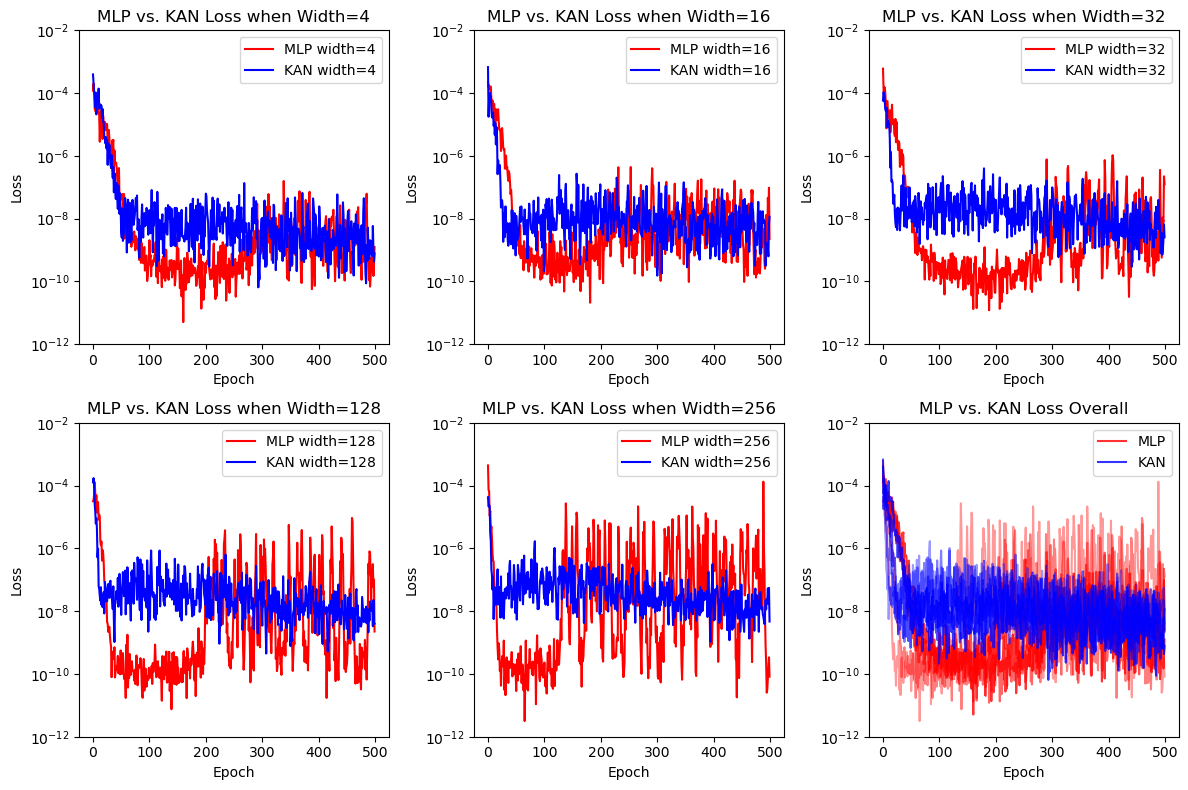

In [63]:
# create 6 subplots for loss
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, mlp_loss in enumerate(mlp_loss_all):
    axs[i//3, i%3].plot(mlp_loss, label='MLP width={}'.format(layers[i]), color='red')
    axs[i//3, i%3].set_yscale('log')
    axs[i//3, i%3].set_title('MLP vs. KAN Loss when Width={}'.format(layers[i]))
    axs[i//3, i%3].set_ylim(1e-12, 1e-2)
    axs[i//3, i%3].set_xlabel('Epoch')
    axs[i//3, i%3].set_ylabel('Loss')
    axs[1, 2].plot(mlp_loss, label='MLP' if i==0 else None, alpha=0.8 - 0.1*i, color='red')


for i, kan_loss in enumerate(kan_loss_width_all):
    axs[i//3, i%3].plot(kan_loss, label='KAN width={}'.format(layers[i]), color='blue')
    axs[1, 2].plot(kan_loss, label='KAN' if i==0 else None, alpha=0.8 - 0.1*i, color='blue')
    axs[i//3, i%3].legend()

axs[1, 2].set_yscale('log')
# set y range
axs[1, 2].set_ylim(1e-12, 1e-2)
axs[1, 2].set_xlabel('Epoch')
axs[1, 2].set_ylabel('Loss')
axs[1, 2].set_title('MLP vs. KAN Loss Overall')
axs[1, 2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# plot the loss by the number of hidden layers of MLP and KAN
plt.plot(layers, [kan_loss[-1] for kan_loss in kan_loss_width_all])
plt.xlabel('Hidden layer width')
plt.ylabel('MSE loss')
plt.title('KAN loss by hidden layer width')
plt.show()

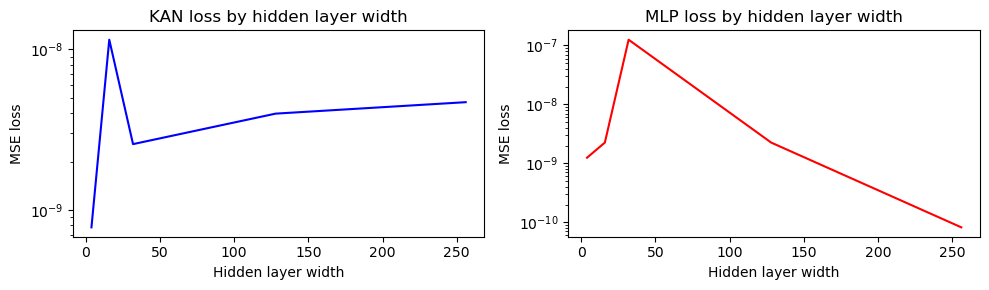

In [58]:
# plot the loss by the number of hidden layers of MLP and KAN in two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(layers, [kan_loss[-1] for kan_loss in kan_loss_width_all], color='blue')
axs[0].set_xlabel('Hidden layer width')
axs[0].set_ylabel('MSE loss')
axs[0].set_yscale('log')
axs[0].set_title('KAN loss by hidden layer width')

axs[1].plot(layers, [mlp_loss[-1] for mlp_loss in mlp_loss_all], color='red')
axs[1].set_xlabel('Hidden layer width')
axs[1].set_ylabel('MSE loss')
axs[1].set_yscale('log')
axs[1].set_title('MLP loss by hidden layer width')
plt.tight_layout()
plt.show()